https://www.hfbrasil.org.br/br/estatistica/batata.aspx

https://cepea.esalq.usp.br/br/consultas-ao-banco-de-dados-do-site.aspx


# Imports e globais


In [1]:
import pandas as pd
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import batelada as bt
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from typing import NamedTuple
from collections import defaultdict

figsize = (20, 10)


In [2]:
import warnings

warnings.filterwarnings("ignore")


In [3]:
arma_keys = {
    "ar.L1",
    "ar.L2",
    "ar.L3",
    "ar.L4",
    "ma.L1",
    "ma.L2",
    "ma.L3",
    "ma.L4",
    "sigma2",
}

ar_keys = {
    "ar.L1",
    "ar.L2",
    "ar.L3",
    "ar.L4",
}


# Funções


In [4]:
def testes_normalidade(resid):
    print(f"D'Agostino's K-squared test: {sp.stats.normaltest(resid)}\n")
    print(f"FKolmogorov-Smirnov test: {sp.stats.kstest(resid, 'norm')}\n")
    print(
        f"Lilliefors test: {sm.stats.diagnostic.lilliefors(resid, dist='norm', pvalmethod='table')}\n"
    )
    print(f"Shapiro-Wilk test: {sp.stats.shapiro(resid)}\n")


In [5]:
def plot_resid(t, resid, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.lineplot(x=t, y=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(title)
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Amostra")
    plt.ylabel("Erro")
    plt.grid()
    plt.show()
    plt.close()


In [6]:
def ked_resid(resid, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.kdeplot(x=resid, color="red", linestyle="-", label="Um passo a frente")
    plt.title(
        f"""{title}
    Média: {(resid).mean():.3}
    Desvio padrão: {(resid).std():.3}"""
    )
    plt.legend(labels=["Um passo a frente"])
    plt.xlabel("Erro")
    plt.ylabel("KDE")
    plt.grid()
    plt.show()
    plt.close()


In [7]:
def plot_serie(t, y, yest, title):
    # Plota a figura
    plt.figure(figsize=figsize)
    sns.scatterplot(x=t, y=y, color="green", markers=".", label="Pontos medidos")
    sns.lineplot(x=t, y=yest, color="red", linestyle="-", label="Um passo a frente")
    plt.title(title)
    plt.legend(labels=["Real", "Um passo a frente"])
    plt.xlabel("Amostra")
    plt.ylabel("Saída")
    plt.grid()
    plt.show()
    plt.close()


In [8]:
def plots_metricas_arma(resid, t, y, yest, ar, ma, mse):
    print(f"Modelo ar:{ar} ma:{ma}\n")

    testes_normalidade(resid)
    print(f"Mean Square Error: {mse:.3}\n")

    title = f"Desempenho"
    plot_serie(t, y, yest, title)

    title = f"Residuos"
    plot_resid(t, resid, title)

    title = f"Distribuição dos residuos"
    ked_resid(resid, title)


In [9]:
def plots_metricas_ar(resid, t, y, yest, na, nb, mse):
    print(f"Modelo na:{na} nb:{nb}\n")

    testes_normalidade(resid)
    print(f"Mean Square Error: {mse:.3}\n")

    title = f"Desempenho"
    plot_serie(t, y, yest, title)

    title = f"Residuos"
    plot_resid(t, resid, title)

    title = f"Distribuição dos residuos"
    ked_resid(resid, title)


In [10]:
class ModelResult(NamedTuple):
    resid: np.array
    mse_train: float
    mse_test: float
    params: dict
    yest: np.array


In [11]:
def train_arma(y, train, ar, ma):
    deep = max(ar, ma)
    npts = y.size
    train_size = round(train * len(y))

    arma = SARIMAX(endog=y[:train_size], order=(ar, 0, ma)).fit(disp=False)
    params = dict(zip(arma.param_names, arma.params))
    arma = arma.append(endog=y[train_size:], refit=False)
    yest = arma.predict(0, len(y) - 1)

    resid = y - yest
    mse_train = np.sum((y[:train_size] - yest[:train_size]) ** 2) / (train_size)
    mse_test = np.sum((y[train_size:] - yest[train_size:]) ** 2) / (npts - train_size)
    return ModelResult(resid, mse_train, mse_test, params, yest)


In [12]:
def train_ar(u, y, train, na, nb):
    deep = max(na, nb)
    npts = y.size
    delay = 0
    train_size = round(train * len(y))

    yest, theta = bt.gerar_dados(na, nb, u, y, delay, train=0.7)
    params = {f"ar.L{i+1}": t for i, t in enumerate(theta)}

    resid = y - yest
    mse_train = np.sum((y[:train_size] - yest[:train_size]) ** 2) / (train_size - deep)
    mse_test = np.sum((y[train_size:] - yest[train_size:]) ** 2) / (
        npts - deep - train_size
    )
    return ModelResult(resid, mse_train, mse_test, params, yest)


In [13]:
def run_arma(y, train):
    mse_low = np.Inf
    best = (0, 0)
    params_total = defaultdict(list)

    for ar, ma in product(range(1, 5), range(1, 5)):
        _, mse_train, mse_test, params, _ = train_arma(y, train, ar, ma)

        params_total["ar"].append(ar)
        params_total["ma"].append(ma)

        for key, value in params.items():
            params_total[key].append(value)

        for key in arma_keys - params.keys():
            params_total[key].append(None)

        params_total["mse.train"].append(mse_train)
        params_total["mse.test"].append(mse_test)

        if mse_low > mse_test:
            best = (ar, ma)
            mse_low = mse_test

    return best, params_total


In [14]:
def run_ar(u, y, train):
    mse_low = np.Inf
    best = 0
    params_total = defaultdict(list)

    for na in range(1, 5):
        _, mse_train, mse_test, params, _ = train_ar(u, y, train, na, 0)
        params_total["na"].append(na)
        if mse_low > mse_test:
            best = na
            mse_low = mse_test

        for key, value in params.items():
            params_total[key].append(value)

        for key in ar_keys - params.keys():
            params_total[key].append(None)

        params_total["mse.train"].append(mse_train)
        params_total["mse.test"].append(mse_test)
    return best, params_total

# Batata


## Pré-processamento


In [15]:
df_batata = pd.read_excel("20221001214857-precos-medios-batata.xlsx")
df_batata = pl.DataFrame(df_batata)
date_batata = df_batata.select(
    pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=pl.col("Dia")).alias("Data")
)
df_batata = df_batata.with_column(date_batata.to_series())


In [16]:
df_agata = df_batata.filter(
    (pl.col("Produto") == "Padrão agata primeira - beneficiador")
    & (pl.col("Unidade") == "saco 50 kg")
    & (pl.col("Data").is_between(pl.datetime(2008, 1, 1), pl.datetime(2020, 12, 31)))
).select(["Data", "Preço", "Ano", "Mês"])


df_agata = (
    df_agata.groupby(["Ano", "Mês"])
    .agg(
        [
            pl.col("Preço").mean().alias("Preço médio"),
            pl.col("Preço").std().alias("Preço desvio"),
            pl.col("Preço").min().alias("Preço menor"),
            pl.col("Preço").max().alias("Preço maior"),
        ]
    )
    .select(
        [
            pl.all(),
            pl.date(year=pl.col("Ano"), month=pl.col("Mês"), day=1).alias("Data"),
        ]
    )
    .sort("Data")
)

df_agata = df_agata.upsample("Data", "1mo").interpolate().fill_null("forward")


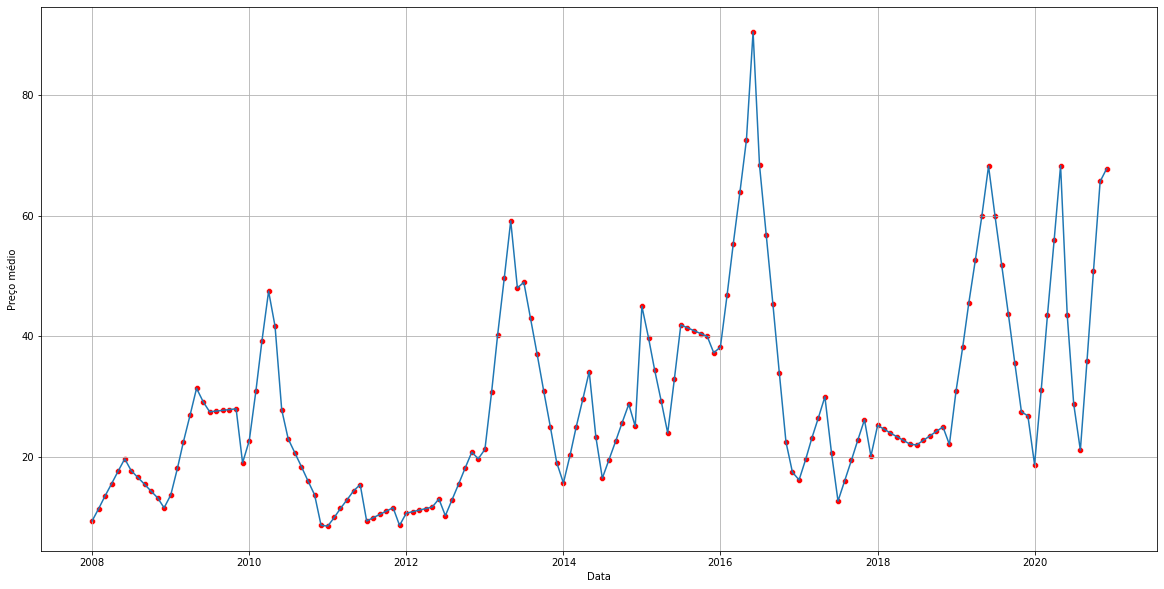

In [17]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_agata.to_pandas(), x="Data", y="Preço médio")
sns.scatterplot(data=df_agata.to_pandas(), x="Data", y="Preço médio", color="red")
plt.grid()
plt.show()
plt.close()


## Carregar dados


In [18]:
data = df_agata.select(["Mês", "Preço médio"]).to_numpy()

u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")
train, t = 0.7, np.arange(len(y))


Número de pontos: 156


## Modelo AR


Modelo ar:4 ma:0

D'Agostino's K-squared test: NormaltestResult(statistic=35.112953318303134, pvalue=2.3731165345961686e-08)

FKolmogorov-Smirnov test: KstestResult(statistic=0.2829356297064548, pvalue=1.5292943903255566e-11)

Lilliefors test: (0.09828979341008348, 0.0020793904212572994)

Shapiro-Wilk test: ShapiroResult(statistic=0.9234163165092468, pvalue=2.264215339664588e-07)

Mean Square Error: 0.233



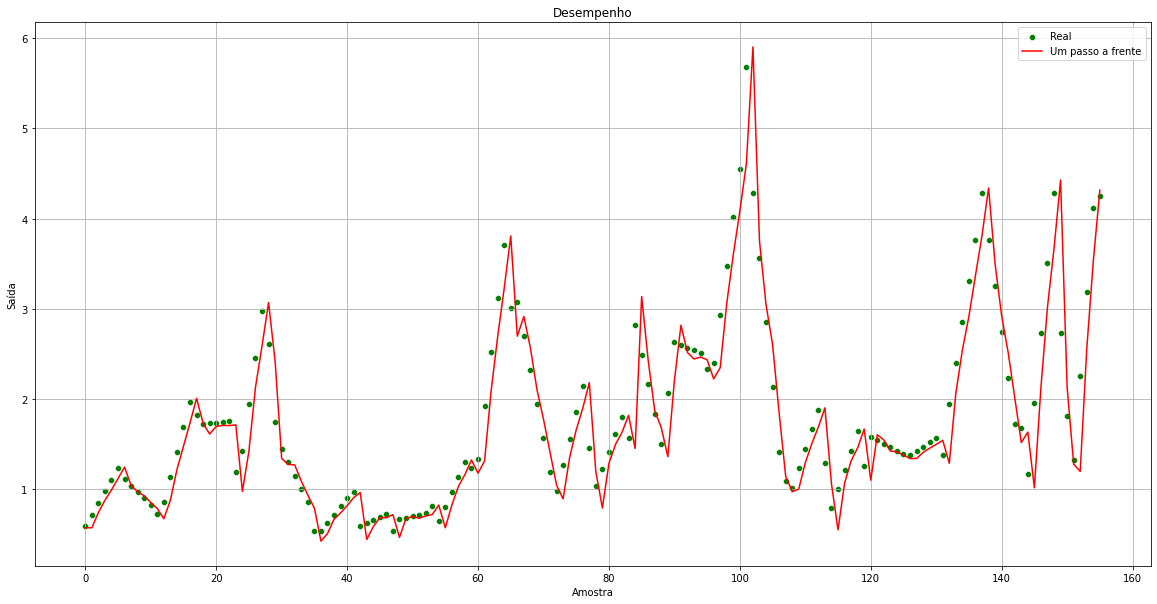

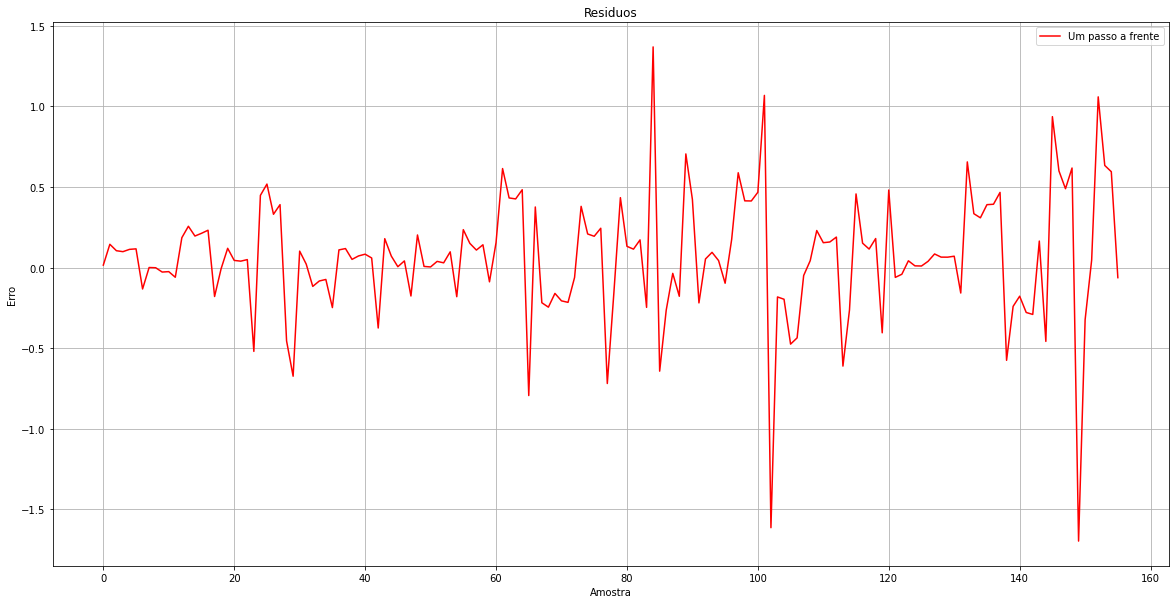

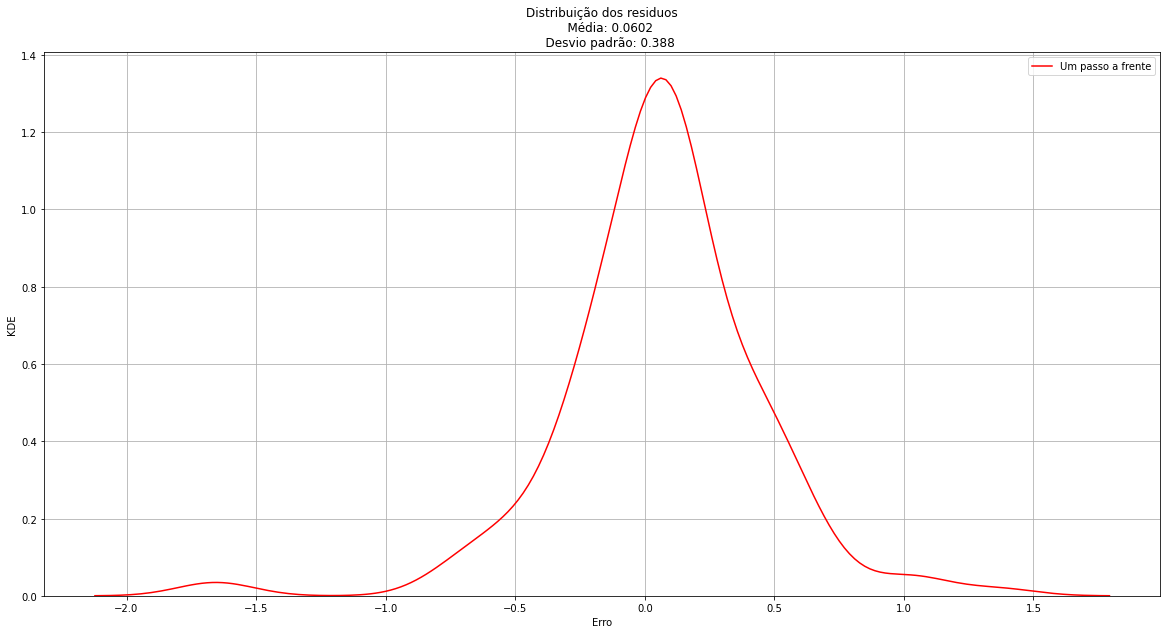

na,ar.L1,ar.L2,ar.L3,ar.L4,mse.train,mse.test
i64,f64,f64,f64,f64,f64,f64
1,-0.980899,null,null,null,0.148986,0.281165
2,-1.320345,0.346722,null,null,0.132342,0.2344
3,-1.304422,0.285922,0.046189,null,0.133308,0.243755
4,-1.3085,0.263115,0.155211,-0.084797,0.133649,0.232583


In [19]:
na, params_total = run_ar(u, y, train)
resid, mse_train, mse_test, params, yest = train_ar(u, y, train, na, 0)
plots_metricas_arma(resid, t, y, yest, na, 0, mse_test)
summarized_results = pl.DataFrame(params_total)
summarized_results[["na"] + sorted(list(ar_keys)) + ["mse.train", "mse.test"]]


## Modelo ARMA


Modelo ar:4 ma:4

D'Agostino's K-squared test: NormaltestResult(statistic=22.891524730823342, pvalue=1.0694698940182447e-05)

FKolmogorov-Smirnov test: KstestResult(statistic=0.2884199264027345, pvalue=5.525475538763243e-12)

Lilliefors test: (0.11038506285483685, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.9283058047294617, pvalue=4.904987918052939e-07)

Mean Square Error: 0.189



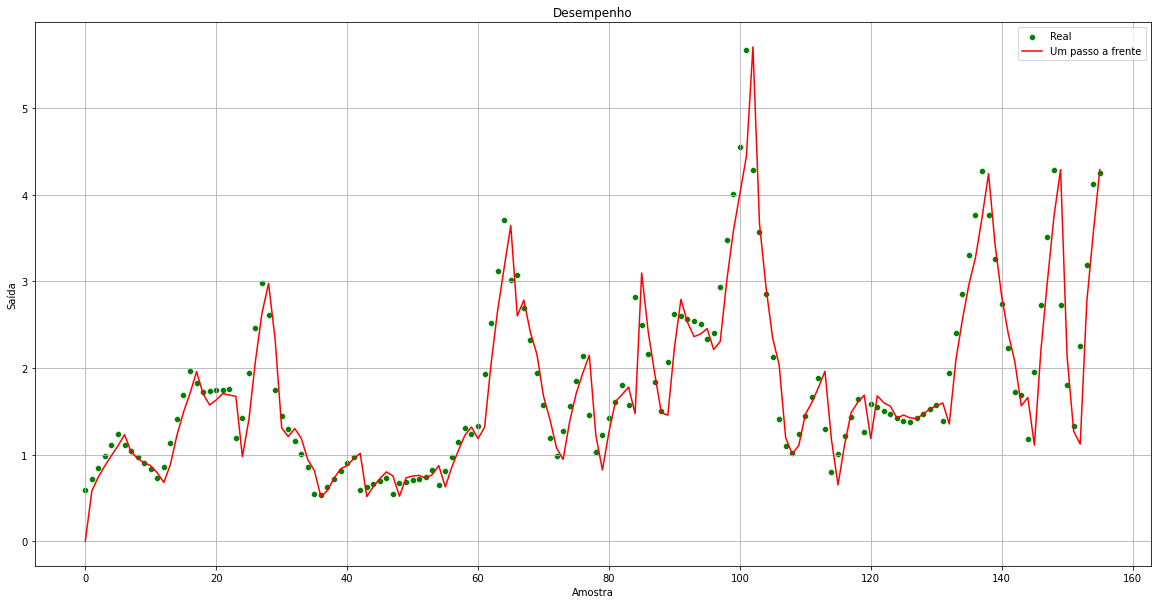

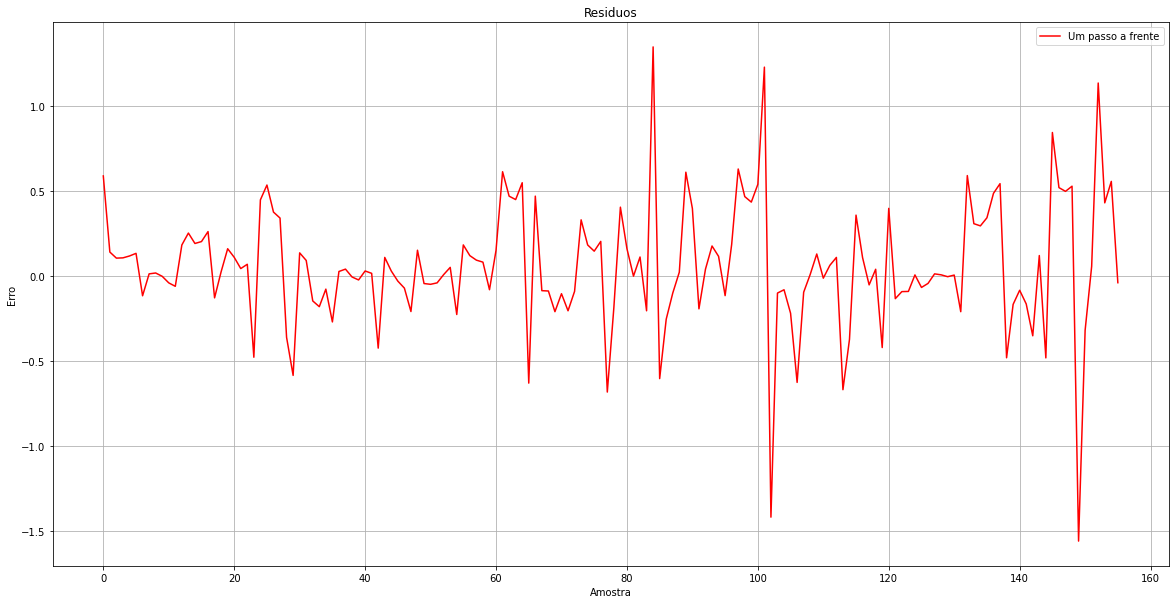

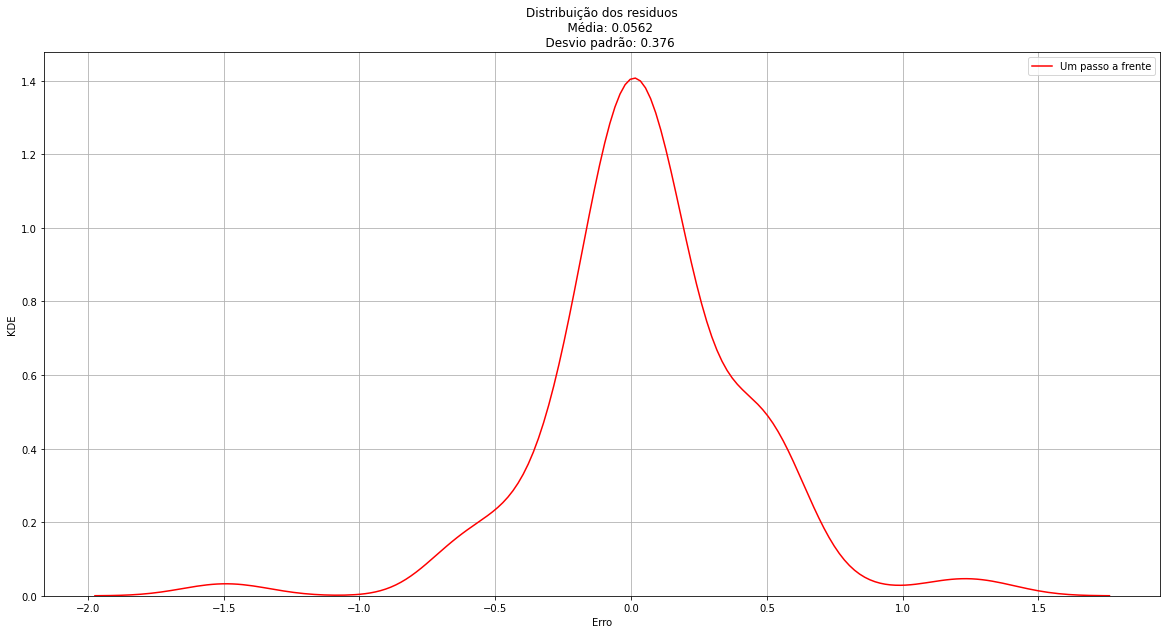

ar,ma,ar.L1,ar.L2,ar.L3,ar.L4,ma.L1,ma.L2,ma.L3,ma.L4,sigma2,mse.train,mse.test
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,1,0.964103,null,null,null,0.294636,null,null,null,0.133159,0.136228,0.231808
1,2,0.954987,null,null,null,0.314313,0.185875,null,null,0.129583,0.132668,0.219078
1,3,0.943573,null,null,null,0.365154,0.2432,0.1145,null,0.128005,0.131102,0.221187
1,4,0.959113,null,null,null,0.325507,0.193964,0.037165,-0.122746,0.126576,0.129676,0.205266
2,1,1.3846,-0.413745,null,null,-0.083965,null,null,null,0.129901,0.132987,0.228264
2,2,1.185353,-0.224705,null,null,0.1017,0.141754,null,null,0.128933,0.132024,0.221116
2,3,1.844939,-0.845096,null,null,-0.629935,-0.117766,-0.221345,null,0.125364,0.128747,0.199539
2,4,1.7396,-0.740024,null,null,-0.483704,-0.098796,-0.153621,-0.193616,0.1216,0.124889,0.190273
3,1,1.072414,0.016206,-0.127639,null,0.219911,null,null,null,0.1296,0.132767,0.227911


In [20]:
(ar, ma), params_total = run_arma(y, train)
resid, mse_train, mse_test, params, yest = train_arma(y, train, ar, ma)
plots_metricas_arma(resid, t, y, yest, ar, ma, mse_test)
summarized_results = pl.DataFrame(params_total)
summarized_results[["ar", "ma"] + sorted(list(arma_keys)) + ["mse.train", "mse.test"]]

# Leite


## Pré-processamento


In [21]:
df_leite = pd.read_excel("cepea-consulta-20221001213951-leite.xls")
df_leite = pl.DataFrame(df_leite)
columns = df_leite.columns[1:]
columns = [
    df_leite[c].str.replace(",", ".").str.replace("-", "NaN").apply(float).alias(c)
    for c in columns
]
df_leite = df_leite.with_columns(columns)
df_leite = df_leite.with_column(
    ("01/" + pl.col("Data")).str.strptime(pl.Date, fmt="%d/%m/%Y").alias("Data")
)
df_leite = df_leite.select(
    [pl.col("Data"), pl.col("Preço líquido médio").alias("Preço")]
)


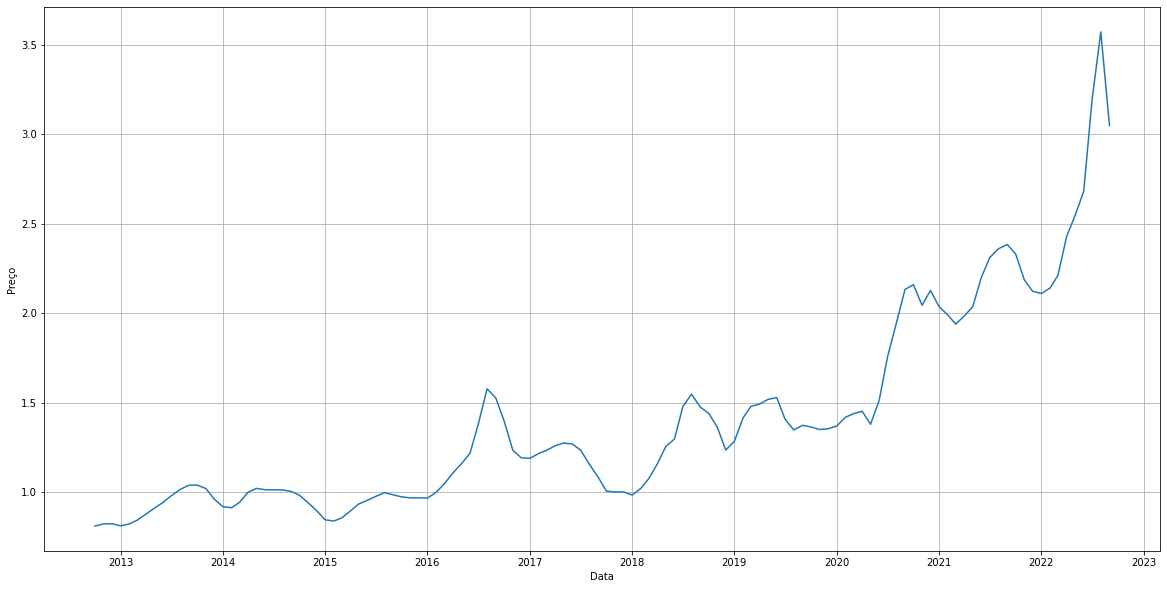

In [22]:
plt.figure(figsize=figsize)
sns.lineplot(data=df_leite.to_pandas(), x="Data", y="Preço")
plt.grid()
plt.show()
plt.close()


## Carregar Dados


In [23]:
data = df_leite.select([pl.col("Data").dt.month(), "Preço"]).to_numpy()

print("Método dos mínimos quadrados em batelada")
u = np.random.normal(
    size=len(data[:, 0])
)  # Entrada aleatória, o algoritmo de LS precisa dela, mas não existem entradas relevantes
y = data[:, 1]  # Salva os dados de saídas

u = u / u.std()
y = y / y.std()

print(f"Número de pontos: {u.size}")
train, t = 0.7, np.arange(len(y))


Método dos mínimos quadrados em batelada
Número de pontos: 120


## Modelo AR


Modelo ar:3 ma:0

D'Agostino's K-squared test: NormaltestResult(statistic=85.62831105293031, pvalue=2.5471147307328913e-19)

FKolmogorov-Smirnov test: KstestResult(statistic=0.3982507447339736, pvalue=1.10698485679656e-17)

Lilliefors test: (0.19856571770420084, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.7028815746307373, pvalue=2.9050421329569406e-14)

Mean Square Error: 0.0844



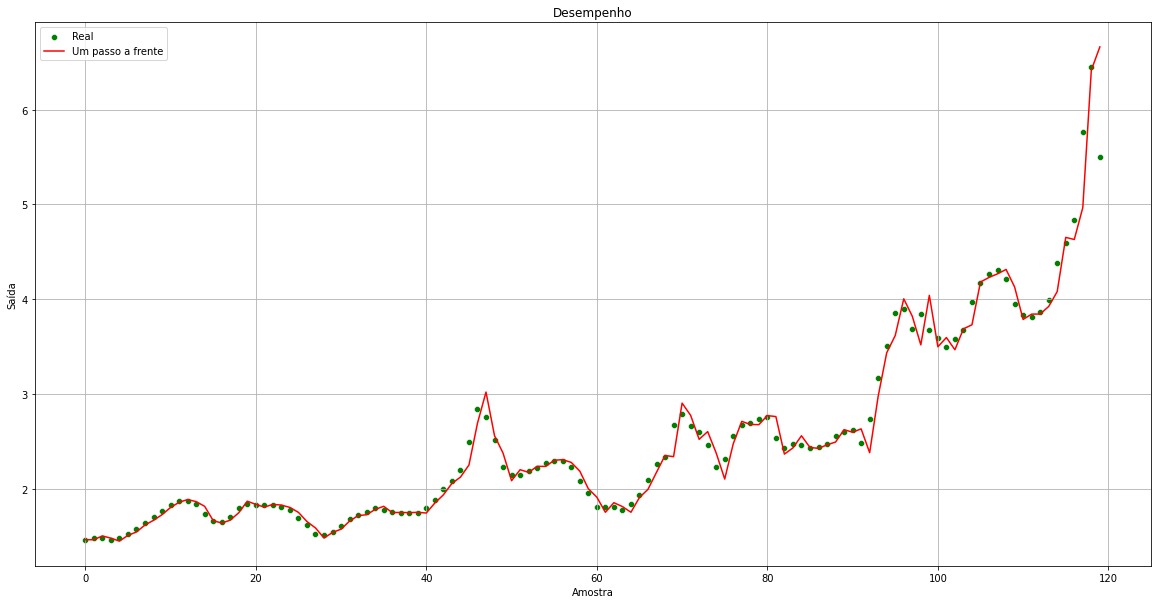

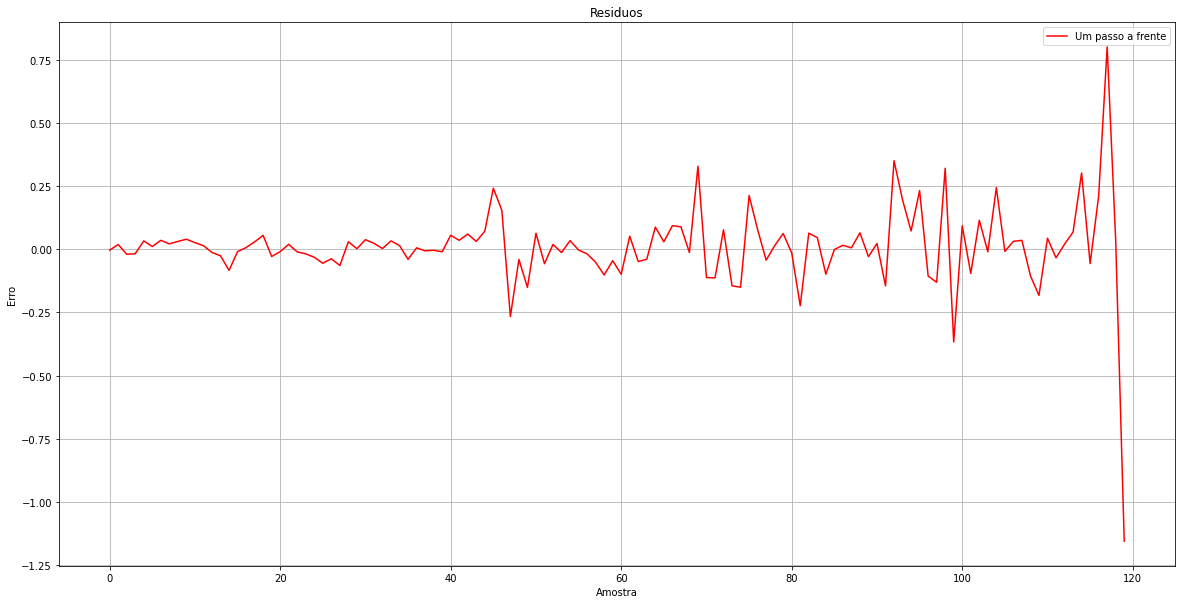

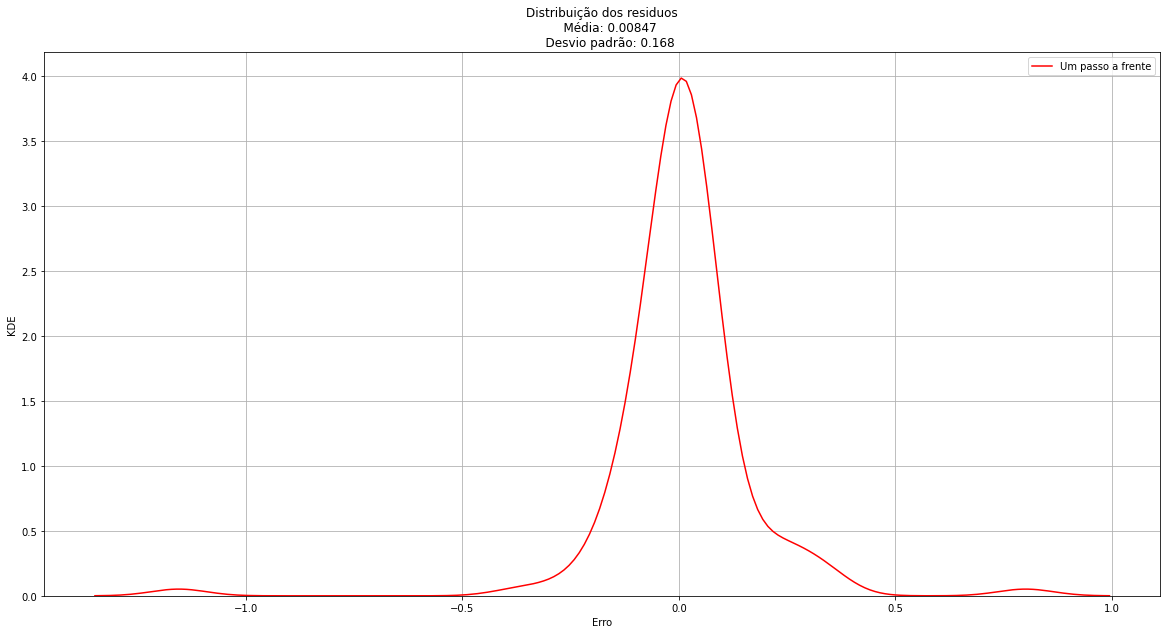

na,ar.L1,ar.L2,ar.L3,ar.L4,mse.train,mse.test
i64,f64,f64,f64,f64,f64,f64
1,-1.004318,null,null,null,0.012082,0.0937
2,-1.574555,0.574191,null,null,0.008246,0.093078
3,-1.782401,1.143006,-0.362935,null,0.007297,0.084404
4,-1.784107,1.148614,-0.372,0.005257,0.007388,0.086939


In [24]:
na, params_total = run_ar(u, y, train)
resid, mse_train, mse_test, params, yest = train_ar(u, y, train, na, 0)
plots_metricas_arma(resid, t, y, yest, na, 0, mse_test)
summarized_results = pl.DataFrame(params_total)
summarized_results[["na"] + sorted(list(ar_keys)) + ["mse.train", "mse.test"]]


## Modelo ARMA


Modelo ar:2 ma:3

D'Agostino's K-squared test: NormaltestResult(statistic=98.12096510533327, pvalue=4.935181711609342e-22)

FKolmogorov-Smirnov test: KstestResult(statistic=0.4026479956286596, pvalue=4.428999184990594e-18)

Lilliefors test: (0.23154646129727408, 0.0009999999999998899)

Shapiro-Wilk test: ShapiroResult(statistic=0.6465409994125366, pvalue=1.379936843876647e-15)

Mean Square Error: 0.0713



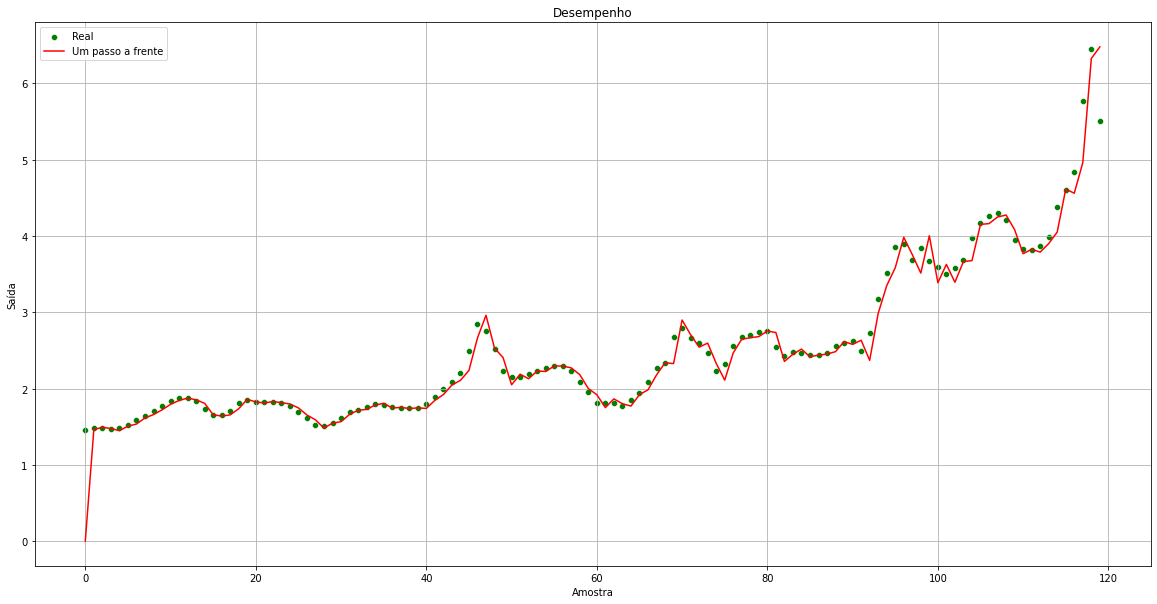

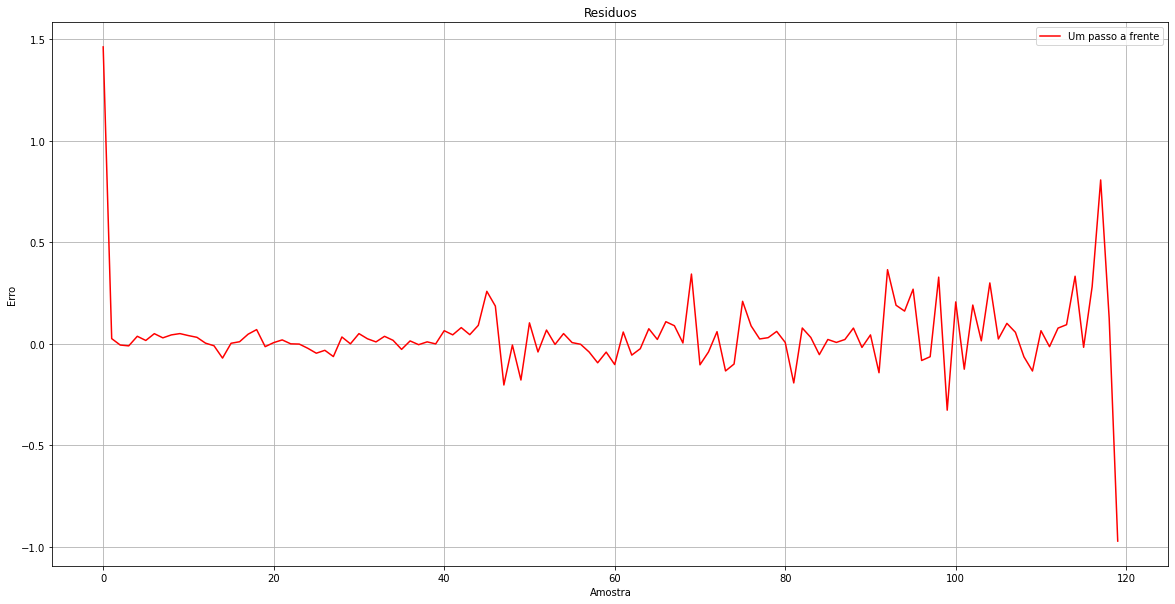

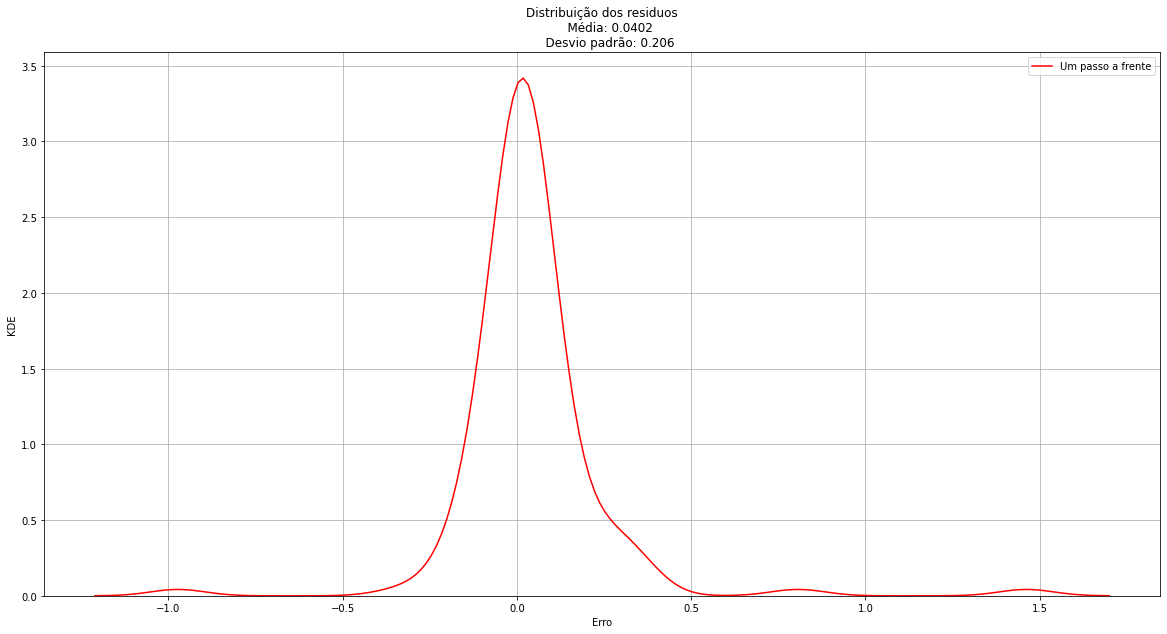

ar,ma,ar.L1,ar.L2,ar.L3,ar.L4,ma.L1,ma.L2,ma.L3,ma.L4,sigma2,mse.train,mse.test
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,1,0.9975,null,null,null,0.675955,null,null,null,0.0073,0.032789,0.0745
1,2,0.996638,null,null,null,0.812123,0.189682,null,null,0.007079,0.032502,0.074604
1,3,0.996552,null,null,null,0.813457,0.201261,0.013734,null,0.007078,0.032501,0.075109
1,4,0.995894,null,null,null,0.831638,0.2402,0.079966,0.056002,0.007068,0.032489,0.075245
2,1,0.317605,0.679463,null,null,0.999121,null,null,null,0.010177,0.035765,0.121716
2,2,1.883379,-0.883462,null,null,-0.253678,-0.643296,null,null,0.007279,0.032696,0.073979
2,3,1.791155,-0.791345,null,null,-0.029399,-0.549476,-0.224928,null,0.0068,0.032294,0.071301
2,4,0.187848,0.801,null,null,1.638231,0.913854,0.253203,0.073621,0.007129,0.032487,0.073672
3,1,0.639244,0.854726,-0.498336,null,0.995751,null,null,null,0.0077,0.033264,0.096724


In [25]:
(ar, ma), params_total = run_arma(y, train)
resid, mse_train, mse_test, params, yest = train_arma(y, train, ar, ma)
plots_metricas_arma(resid, t, y, yest, ar, ma, mse_test)
summarized_results = pl.DataFrame(params_total)
summarized_results[["ar", "ma"] + sorted(list(arma_keys)) + ["mse.train", "mse.test"]]